**This notebook demonstrates the advantage of ensemble learning models in image classification. We start by training 3 classifiers. We then average their predictions to decied our final classificaion. As I show here, this results in a better test accuracy.**

In [2]:
import numpy as np 
import cv2
import os
import shutil
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import applications
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization

In [3]:
# path to image folders
yes=os.listdir('brain_tumor_dataset/yes')
no=os.listdir('brain_tumor_dataset/no')

X_data =[]
for file in yes:
    img = cv2.imread('brain_tumor_dataset/yes/'+file)
    face = cv2.resize(img, (224, 224))
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    X_data.append(img)

for file in no:
    img = cv2.imread('brain_tumor_dataset/no/'+file)
    face = cv2.resize(img, (224, 224))
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    X_data.append(img)
X = np.squeeze(X_data)
X.shape

(253, 224, 224, 3)

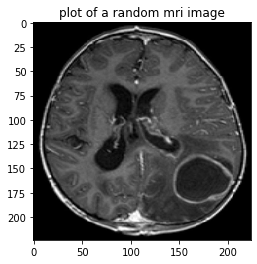

In [4]:
from random import randrange
plt.imshow(X[randrange(253)], interpolation='nearest')
plt.title('plot of a random mri image')
plt.show()

In [5]:
X = X.astype('float32')
X /= 255.
y_yes = np.full(len(yes),1)
y_no = np.full(len(no),0)
y=np.concatenate([y_yes,y_no])
y.shape

(253,)

In [6]:
# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
print("X_train :",X_train.shape,
      "y_train :",y_train.shape,
     "\nX_test :",X_test.shape,
     "y_test :",y_test.shape)

X_train : (202, 224, 224, 3) y_train : (202,) 
X_test : (51, 224, 224, 3) y_test : (51,)


**This method takes in a base model, like InceptionV3, and builds a binary classifer based on the pretrained parameters of that model. We will create 4 different classifiers and train them on the tumor dataset.**

In [10]:
def create_model(base_model, name='model'):
  base_model.trainable = False
  model = Sequential(name=name)
  model.add(base_model)
  model.add(tf.keras.layers.GlobalAveragePooling2D())
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(1024, activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
  return model

In [17]:
base1 = applications.InceptionV3(weights='imagenet', 
                                  include_top=False, 
                                  input_shape=(224, 224,3))
base2 = applications.ResNet50V2(weights='imagenet', 
                                  include_top=False, 
                                  input_shape=(224, 224,3))
base3 = applications.VGG16(weights='imagenet', 
                                  include_top=False, 
                                  input_shape=(224, 224,3))
base4 = applications.Xception(weights='imagenet', 
                                  include_top=False, 
                                  input_shape=(224, 224,3))
model1 = create_model(base1, name='inception_based_model')
model2 = create_model(base2, name='ResNet50V2_based_model')
model3 = create_model(base3, name='VGG16_based_model')
model4 = create_model(base4, name='Xception_based_model')

In [18]:
print(model1.summary())
print('\n\n')
print(model2.summary())
print('\n\n')
print(model3.summary())
print('\n\n')
print(model4.summary())

Model: "inception_based_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)     

In [19]:
import time
def show_results(history, model_name, duration, results):
  print('It took', duration, 'seconds to train', model_name, 'for 50 epochs.')
  print('Training accuracy after 50 epochs: %.4f'%history.history['accuracy'][-1])
  print("test loss, test accuracy:", results)
  # plot the loss curves
  plt.plot(history.history['loss'])
  plt.title(model_name + ' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.show()

51/51 [==============================] - 1s 28ms/step - loss: 0.4136 - accuracy: 0.8627
It took 62.08602833747864 seconds to train inception_based_model for 50 epochs.
Training accuracy after 50 epochs: 0.9851
test loss, test accuracy: [0.41364723443984985, 0.8627451062202454]


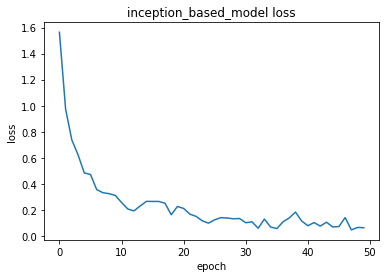

In [20]:
start = time.time()
# fit the parameters
history1 = model1.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=50,
    verbose = 0)
duration1 = time.time()-start
results1 = model1.evaluate(X_test, y_test, batch_size=1)
show_results(history1, 'inception_based_model', duration1, results1)

**The inception based model acheives great training accuracy in 50 epochs, but it's test accuracy is not ideal. We'll improve it later by combining this model with two other models.**

**ResNet50 performs well**

It took 66.87845635414124 seconds to train ResNet50V2_based_model for 50 epochs.
Training accuracy after 50 epochs: 0.9653
test loss, test accuracy: [0.6426260471343994, 0.8627451062202454]


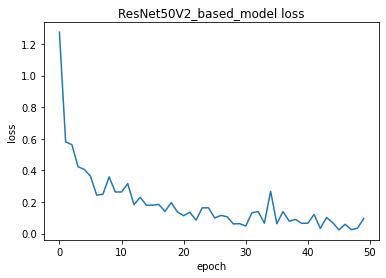

In [21]:
start = time.time()
# fit the parameters
history2 = model2.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=50,
    verbose = 0)
duration2 = time.time()-start
results2 = model2.evaluate(X_test, y_test, batch_size=1, verbose=0)
show_results(history2, 'ResNet50V2_based_model', duration2, results2)

It took 95.92227482795715 seconds to train VGG16_based_model for 50 epochs.
Training accuracy after 50 epochs: 0.8168
test loss, test accuracy: [0.3037477433681488, 0.8627451062202454]


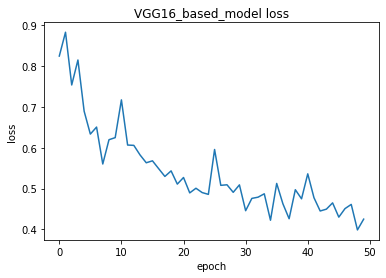

In [22]:
start = time.time()
# fit the parameters
history3 = model3.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=50,
    verbose = 0)
duration3 = time.time()-start
results3 = model3.evaluate(X_test, y_test, batch_size=1, verbose=0)
show_results(history3, 'VGG16_based_model', duration3, results3)

**VGG16 performs relatively poorly on the training set. I'll remove it from the ensemble.**

It took 103.28788042068481 seconds to train Xception_based_model for 50 epochs.
Training accuracy after 50 epochs: 0.9752
test loss, test accuracy: [0.5072811245918274, 0.8235294222831726]


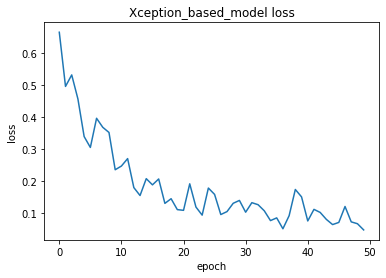

In [23]:
start = time.time()
# fit the parameters
history4 = model4.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=50,
    verbose = 0)
duration4 = time.time()-start
results4 = model4.evaluate(X_test, y_test, batch_size=1, verbose=0)
show_results(history4, 'Xception_based_model', duration4, results4)

**Xception looks good! We will use model1, model2, and model4 to build our ensemble. <br>The output of the ensemble in this case is just an average of the outputs of the three models.**

In [75]:
correct = 0
for i in range(X_test.shape[0]):
  pred = model1.predict(X_test[i].reshape(1,224,224,3)).item()
  pred+= model2.predict(X_test[i].reshape(1,224,224,3)).item()
  pred+= model4.predict(X_test[i].reshape(1,224,224,3)).item()
  pred/= 3.
  if(1*(pred>0.5) == y_test[i]):
    correct+=1
print('Remember that we got the following test accuracy results for our three models:')
print('test accuracy for the inception model:%.4f' %results1[1])
print('test accuracy for the ResNet model:%.4f' %results2[1])
print('test accuracy for the Xception model:%.4f' %results4[1])
print("After evaluating the ensemble model, we see that:")
print("Number of correct classifications:", correct)
print("test accuracy for the ensemble model:%.4f" %(correct/X_test.shape[0]))

Remember that we got the following test accuracy results for our three models:
test accuracy for the inception model:0.8627
test accuracy for the ResNet model:0.8627
test accuracy for the Xception model:0.8235
After evaluating the ensemble model, we see that:
Number of correct classifications: 45
test accuracy for the ensemble model:0.8824


###**This is great! By training 3 different models and taking the average of their predictions, we were able to acheive a performance 2% better than the best individual model. This demonstrates that when we have multiple closely performing models, ensemble learning might be a good way to improve their performance.**